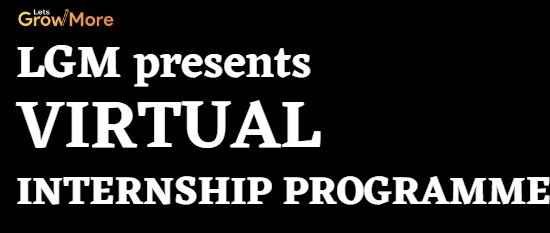

# 2) Music Recommendation
### Name- Mrunalsinh Patil 
#### Batch- Nov 2022

# Importing the Necessary Libraries

In [14]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import string
import math
import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb
import py7zr

# Reading the input file

In [16]:
archive1=py7zr.SevenZipFile(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\kkbox-music-recommendation-challenge\songs.csv.7z")
archive1.extractall(path="C:\\Users\\Mrunal\\Desktop\\mrunal class\\letsgrowmore\\data")

archive2=py7zr.SevenZipFile(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\kkbox-music-recommendation-challenge\song_extra_info.csv.7z")
archive2.extractall(path="C:\\Users\\Mrunal\\Desktop\\mrunal class\\letsgrowmore\\data")

archive3=py7zr.SevenZipFile(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\kkbox-music-recommendation-challenge\members.csv.7z")
archive3.extractall(path="C:\\Users\\Mrunal\\Desktop\\mrunal class\\letsgrowmore\\data")

archive4=py7zr.SevenZipFile(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\kkbox-music-recommendation-challenge\test.csv.7z")
archive4.extractall(path="C:\\Users\\Mrunal\\Desktop\\mrunal class\\letsgrowmore\\data")

archive5=py7zr.SevenZipFile(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\kkbox-music-recommendation-challenge\train.csv.7z")
archive5.extractall(path="C:\\Users\\Mrunal\\Desktop\\mrunal class\\letsgrowmore\\data")

In [17]:
songs_df = pd.read_csv(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\songs.csv")
songs_extra_df = pd.read_csv(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\song_extra_info.csv")
members_df = pd.read_csv(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\members.csv")
train_df = pd.read_csv(r"C:\Users\Mrunal\Desktop\mrunal class\letsgrowmore\data\train.csv", nrows = 100000)
t_s = pd.merge(train_df, songs_df, on='song_id', how='left')
t_s_se = pd.merge(t_s, songs_extra_df, on='song_id', how='left')
songs = pd.merge(t_s_se, members_df, on='msno', how='left')
del songs_df, songs_extra_df, members_df, train_df, t_s, t_s_se
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


# Let's get information about the dataset

In [18]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

# Dealing with the missing values

<AxesSubplot:>

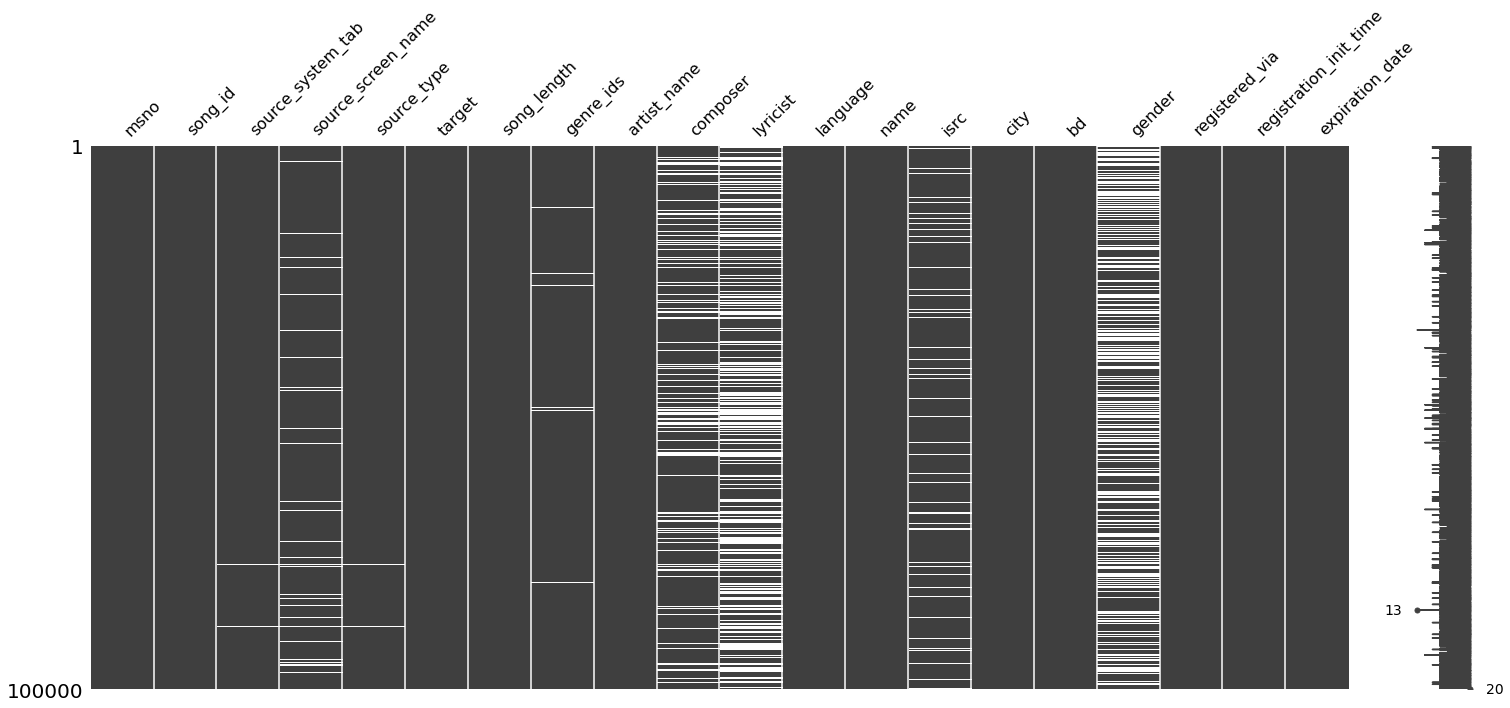

In [19]:
msno.matrix(songs)

In [20]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

# Extracting new features

In [21]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [22]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [23]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

# Сorrelation matrix

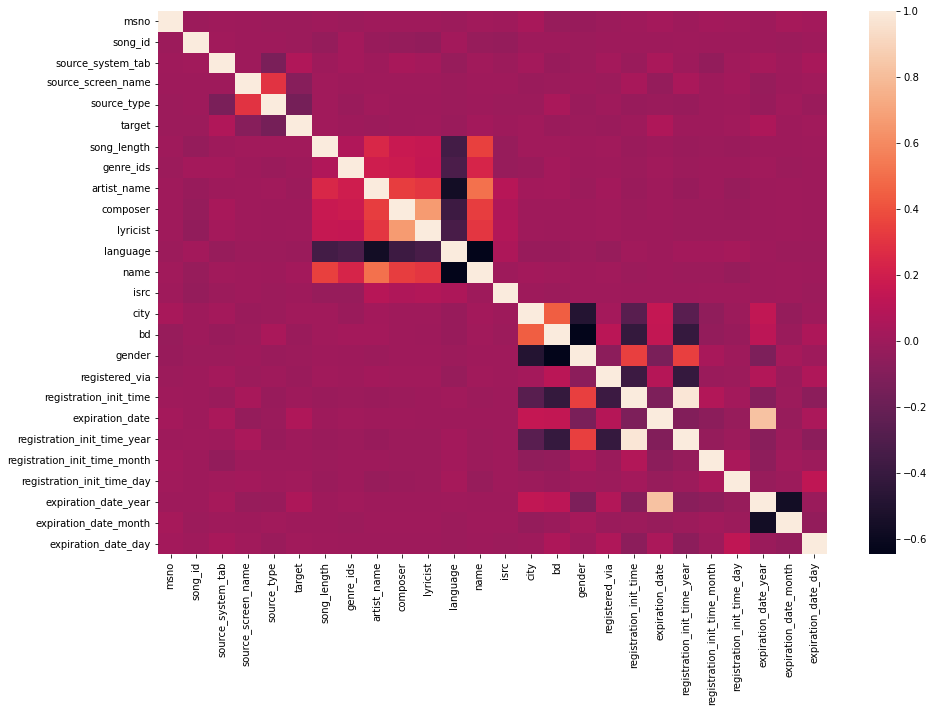

In [24]:
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr())
plt.show()

# Modeling Data

In [26]:
x = songs.drop('target', axis = 1)
y = songs.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [27]:
def model_with(model_name, x_train, x_test, y_train, y_test) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000, 
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1000, 
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=1000, 
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000, 
        )
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(
            n_estimators=1000, 
            verbose=0
        )
    else :
        print("Model not found in function.")
        
    model.fit(x_train, y_train)
    
    val_pred = model.predict(x_test)
    print(classification_report(y_test, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_test, val_pred))
    print("ROC :", roc_auc_score(y_test, val_pred))
    
    print("==================================================")
    print()

In [28]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "LightGBM Classifier", "XGBoost Classifier", "CatBoost Classifier"]
for i in models :
    model_with(i, x_train, x_test, y_train, y_test)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      6176
           1       0.87      0.94      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.75      0.78     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.84896
ROC : 0.7545176797231624

Modeling with : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      6176
           1       0.87      0.93      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.76      0.78     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.84788
ROC : 0.7618512237161688

Modeling with : LightGBM Classifier

              precision    recall  f1-score   support

           0       0.75      0.53      0.63      6176
           1       0.86   

In [29]:
rf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1.0050505050505052, 1: 0.9949494949494948}
)

rf.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 1.0050505050505052,
                                     1: 0.9949494949494948},
                       n_estimators=1000)

In [ ]:
val_pred = rf.predict(x_test)
print("Accuracy :", accuracy_score(y_test, val_pred))